In [148]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [149]:
# Alterar o nome do papel conforme necessário
ticker_name = "VALE3.SA"

In [150]:
# Carregar os dados do CSV para o histórico de mercado
ticker_history = pd.read_csv(f"./data/{ticker_name}.csv", header=[0, 1], index_col=0)
ticker_history.head()

Price,Close,High,Low,Open,Volume
Ticker,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA
Date,,,,,
2020-01-02,32.831028,32.897498,32.480539,32.619525,17509700
2020-01-03,32.589310,32.933754,32.377809,32.438237,17284800
2020-01-06,32.395931,32.510745,32.117959,32.510745,32787800
2020-01-07,32.631607,32.746421,32.269035,32.329463,16326400
2020-01-08,32.637653,32.855198,32.401981,32.752470,15298500


In [151]:
# Carregar os dados do CSV para histórico de dividendos. A data marcada é equivalente à data EX, ou seja,
# o dia em que a ação sofreu correção em seu valor. Carregar em uma série por ser apenas uma coluna
ticker_dividend = pd.read_csv(f"./data/{ticker_name}_dividend.csv", index_col=0).squeeze()
ticker_dividend.tail()

Date
2023-08-14 00:00:00-03:00    1.918472
2024-03-12 00:00:00-03:00    2.738548
2024-08-05 00:00:00-03:00    2.093798
2024-12-12 00:00:00-03:00    0.520531
2025-03-10 00:00:00-03:00    2.141847
Name: Dividends, dtype: float64

# Encontrar curva de recuperação normalizada
Vamos utilizar algumas data com passadas, normalizar os dados de fechamento com o valor pago do dividendo e descobrir um padrão. Esse padrão vai ser necessário para prever o gráfico futuro após a próxima data com.

`Close_D0` = Primeiro dia de fechamento da série. A normalização será dividir o preço de cada dia por ele.

# TO-DO:
Estou usando apenas o valor CLOSE. Precisa também usar high, low, open e volume para ser mais preciso. Usar PCA nas variáveis correlacionadas. Fazer igual trabalho passado.

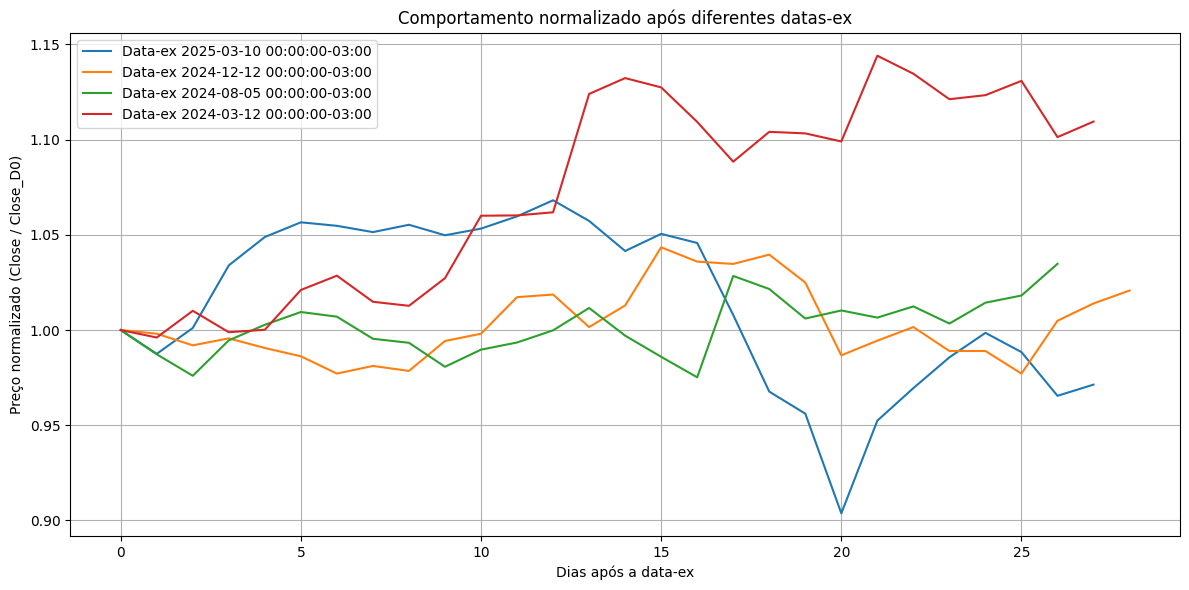

In [152]:
# Juntar dados das últimas data com
total_dates = 5
count_days = 40
curvas_normalizadas = []
df_curves = pd.DataFrame(columns=["Ticker", "Price Normalized"])

for i in range(1, total_dates + 1):
    ex_date = pd.to_datetime(ticker_dividend.index[-i]).replace(tzinfo=None)
    valor_provento = ticker_dividend.iloc[-i]
    
    # Obter histórico de 30 dias após a data-ex
    start_date = ex_date
    end_date = ex_date + pd.Timedelta(days=count_days)
    historico = ticker_history[(pd.to_datetime(ticker_history.index) > start_date) & (pd.to_datetime(ticker_history.index) < end_date)]
    
    # Pula se não tiver dados suficientes. É descontado 15 para ter ao menos 2 semanas de dias úteis
    history_length = len(historico)
    if history_length < count_days - 15:
        continue

    preco_base = historico.iloc[0]["Close"]
    curva_normalizada = historico["Close"].iloc[:count_days] / preco_base
    curva_normalizada.index = range(history_length)  # reinicia índice como dias
    curvas_normalizadas.append(curva_normalizada)

    df_curves = pd.concat([df_curves, curva_normalizada], ignore_index=True)

# Plotar todas as curvas no mesmo gráfico
plt.figure(figsize=(12, 6))
for i, curva in enumerate(curvas_normalizadas):
    plt.plot(curva, label=f"Data-ex {ticker_dividend.index[-(i+1)]}")

plt.title("Comportamento normalizado após diferentes datas-ex")
plt.xlabel("Dias após a data-ex")
plt.ylabel("Preço normalizado (Close / Close_D0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Normalizar a curva final
O código acima encontra todas as curvas das data ex que queremos. Agora, iremos normalizar cada curva em uma única usando **desvio padrão diário**.

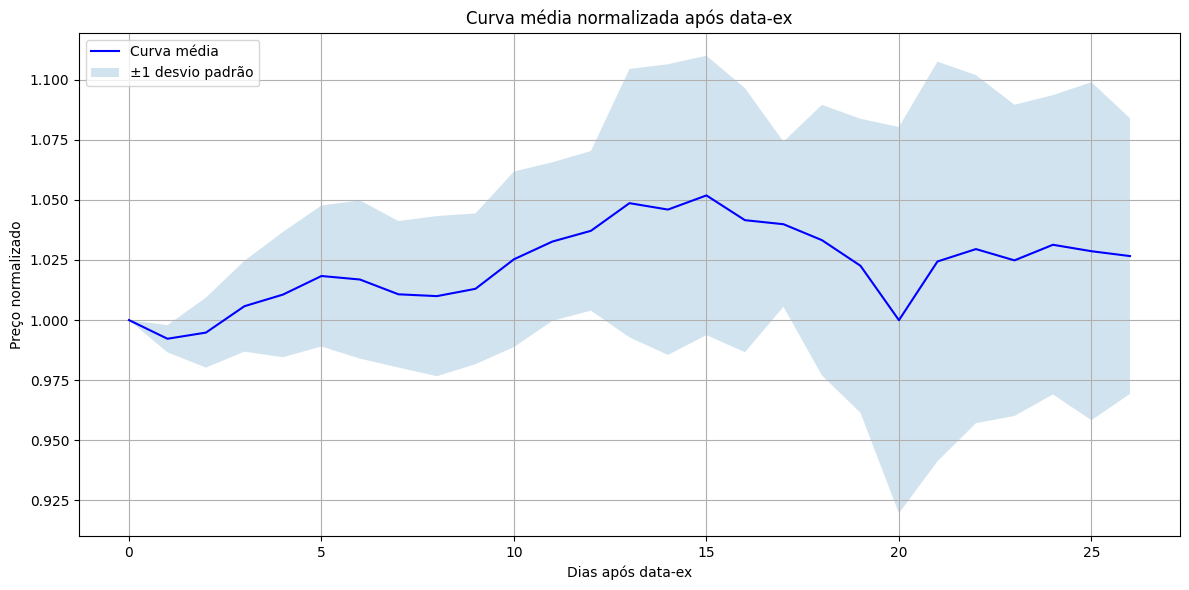

In [153]:
# Juntar todas as curvas em um DataFrame
df_curvas = pd.concat(curvas_normalizadas, axis=1).T
df_curvas = df_curvas.dropna(axis=1)  # remove dias incompletos

# Calcular média e desvio padrão por dia
media = df_curvas.mean()
desvio = df_curvas.std()

plt.figure(figsize=(12, 6))
plt.plot(media, label="Curva média", color="blue")
plt.fill_between(media.index, media - desvio, media + desvio, alpha=0.2, label="±1 desvio padrão")
plt.title("Curva média normalizada após data-ex")
plt.xlabel("Dias após data-ex")
plt.ylabel("Preço normalizado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Algoritmo de predição para a DATA COM
Como a data com ainda está no futuro, precisamos saber qual é a linha gráfica que a ação vai fazer até chegar neste dia.

In [154]:
# Data de exemplo
next_ex_date = pd.to_datetime("2025-05-24 00:00:00-03:00")

In [155]:
# Conferir matriz de correlação entre variáveis independentes
print(ticker_history[['Open', 'High', 'Low', 'Volume']].corr())

Price                Open      High       Low    Volume
Ticker           VALE3.SA  VALE3.SA  VALE3.SA  VALE3.SA
Price  Ticker                                          
Open   VALE3.SA  1.000000  0.998869  0.998884 -0.130650
High   VALE3.SA  0.998869  1.000000  0.998657 -0.116871
Low    VALE3.SA  0.998884  0.998657  1.000000 -0.141556
Volume VALE3.SA -0.130650 -0.116871 -0.141556  1.000000


In [156]:
# Usar últimos 6 meses de dados
today = pd.Timestamp.today()
count_days = 6 * 22
period = today - pd.Timedelta(days=count_days)

ticker_history = pd.read_csv(f"./data/{ticker_name}.csv", header=[0, 1], index_col=0)
ticker_data = ticker_history[pd.to_datetime(ticker_history.index) > period]
ticker_data.head()

Price,Close,High,Low,Open,Volume
Ticker,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA,VALE3.SA
Date,,,,,
2024-12-30,52.500935,53.116894,52.500935,52.837790,11250900
2025-01-02,52.212204,53.030274,52.192955,52.654924,17623900
2025-01-03,51.240143,51.971593,50.893665,51.875351,23608700
2025-01-06,50.585686,51.769483,50.508689,51.471126,21689500
2025-01-07,50.094841,50.903288,49.988972,50.653056,22070200


In [157]:
# Criação do rótulo: fechamento do dia seguinte
ticker_data['Label'] = ticker_data['Close'].shift(-1)
ticker_data.dropna(inplace=True)

# Nossos atributos
# Dividido em X_base e X_volume pois 'Open', 'High' e 'Low' são fortemente correlacionados
# e resultarão em uma razão
X_base = ticker_data[['Open', 'High', 'Low']]
X_volume = ticker_data[['Volume']]
y = ticker_data['Label']

C:\Users\Leonardo Gianfagna\AppData\Local\Temp\ipykernel_15088\2639558904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Label'] = ticker_data['Close'].shift(-1)
C:\Users\Leonardo Gianfagna\AppData\Local\Temp\ipykernel_15088\2639558904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data.dropna(inplace=True)


In [158]:
# Normalizar os dados (tanto agora da base e volume)
scaler_base = StandardScaler()
X_base_scaled = scaler_base.fit_transform(X_base)

scaler_vol = StandardScaler()
X_vol_scaled = scaler_vol.fit_transform(X_volume)

In [159]:
# Aplicar PCA só em Open, High, Low
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_base_scaled)

# Concatenar os componentes com o volume padronizado
X_final = np.hstack([X_pca, X_vol_scaled])

# Dividir o dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42)

In [160]:
# Regressão linear
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Visualização do treinamento
Ver em um gráfico como foi o treinamento do algoritmo de regressão linear, para ver o quão efetivo será ele para prever quanto estará o valor da data COM no dia anunciado pela empresa.

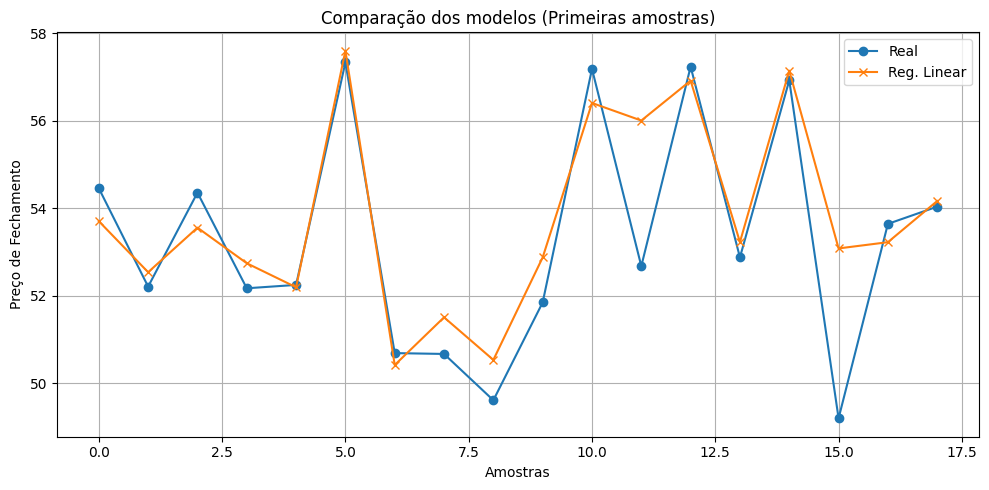

In [161]:
num_amostras = len(y_test)

plt.figure(figsize=(10, 5))
plt.plot(range(num_amostras), y_test.values[:num_amostras], label="Real", marker='o')
plt.plot(range(num_amostras), y_pred_lr[:num_amostras], label="Reg. Linear", marker='x')
plt.title("Comparação dos modelos (Primeiras amostras)")
plt.xlabel("Amostras")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


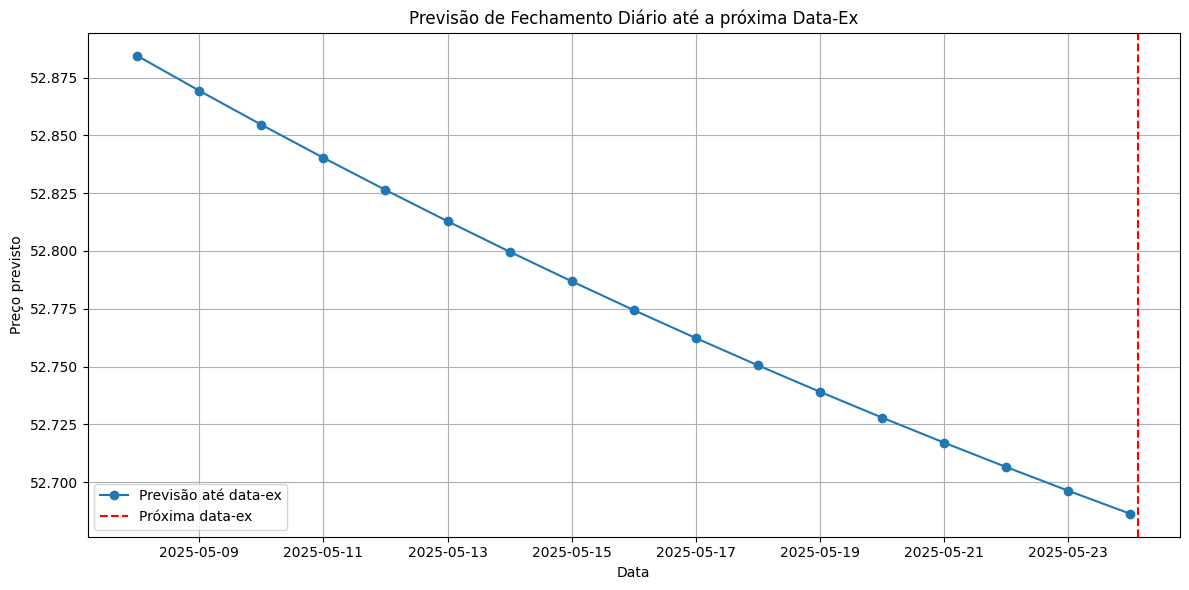

In [167]:
# Supondo que estes já estejam definidos e treinados:
# ticker_data, lr, scaler_base, scaler_vol, pca
# E a variável next_ex_date
# Exemplo para testar: next_ex_date = pd.to_datetime("2025-05-24")

# Início da previsão: último dia real
data_atual = pd.to_datetime(ticker_data.index[-1]).replace(tzinfo=None)
preco_ultimo_fechamento = ticker_data.iloc[-1]["Close"]

# Usar o último volume como base
volume_base = ticker_data["Volume"].iloc[-5:].mean()

# Armazenar previsões
datas_previstas = []
precos_previstos = []

while data_atual.replace(tzinfo=None) < next_ex_date.replace(tzinfo=None):
    # Simular dados do próximo dia
    open_simulado = preco_ultimo_fechamento
    high_simulado = preco_ultimo_fechamento * 1.01
    low_simulado = preco_ultimo_fechamento * 0.99
    volume_simulado = volume_base

    # Preparar input
    X_base = np.array([[open_simulado, high_simulado, low_simulado]]).reshape(1, -1)
    X_vol = np.array([[volume_simulado]]).reshape(1, -1)

    # Normalizar e aplicar PCA
    X_base_scaled = scaler_base.transform(X_base)
    X_vol_scaled = scaler_vol.transform(X_vol)
    X_pca = pca.transform(X_base_scaled)
    X_input = np.hstack([X_pca, X_vol_scaled])

    # Prever preço de fechamento
    preco_previsto = lr.predict(X_input)[0]

    # Salvar resultado
    data_atual += pd.Timedelta(days=1)
    datas_previstas.append(data_atual)
    precos_previstos.append(preco_previsto)

    # Atualizar último preço previsto
    preco_ultimo_fechamento = preco_previsto

# Criar DataFrame com os resultados
df_previsao = pd.DataFrame({
    "Data": datas_previstas,
    "Preco_Previsto": precos_previstos
}).set_index("Data")

# Plotar resultados
plt.figure(figsize=(12, 6))
plt.plot(df_previsao.index, df_previsao["Preco_Previsto"], marker='o', label="Previsão até data-ex")
plt.axvline(x=next_ex_date, color='red', linestyle='--', label="Próxima data-ex")
plt.title("Previsão de Fechamento Diário até a próxima Data-Ex")
plt.xlabel("Data")
plt.ylabel("Preço previsto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

